
# Plot Metrics from `results/generated_*`

This notebook scans folders like `results/generated_5`, `results/generated_10`, ..., `results/generated_60`,
reads each `metrics.csv` (columns: `total_waiting_time,total_energy_waste`), and produces **two bar charts**:

1. **Energy Waste vs Folder** — y = `total_energy_waste`, x = folder number (5,10,...,60).
2. **Waiting Time vs Folder** — y = `total_waiting_time`, x = folder number (5,10,...,60).

The figures are also saved to `results/plots/`.


In [107]:

import os
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Inline plots
%matplotlib inline


In [108]:

# Change this if needed
results_dir = Path('results')    # directory containing generated_* folders
output_dir  = results_dir / 'plots'
output_dir.mkdir(parents=True, exist_ok=True)
print('Results dir:', results_dir.resolve())
print('Output dir :', output_dir.resolve())

#pat = re.compile(r'^generated_test_(\d+|mymethod_\d+)$')
#pat = re.compile(r'^generated_test_(mymethod_\d+)$')
#pat = re.compile(r'^generated_test_(\d+)$') 


Results dir: C:\---\SPARS-AIBT-Hasbi\results
Output dir : C:\---\SPARS-AIBT-Hasbi\results\plots


In [ ]:

def collect_metrics(results_dir: Path):
    import re, pandas as pd, os
    
    # Tangkap dua pola: angka (300) atau mymethod_angka (mymethod_300)
    pat = re.compile(r'^generated_test_(\d+|mymethod_\d+)$')
    rows_numeric = []
    rows_mymethod = []
    
    for entry in results_dir.iterdir():
        if not entry.is_dir():
            continue
        m = pat.match(entry.name)
        if not m:
            continue
            
        k_group = m.group(1)
        csv_path = entry / 'metrics.csv'
        if not csv_path.is_file():
            continue
            
        try:
            df = pd.read_csv(csv_path)
            cols = [c.lower().strip() for c in df.columns.tolist()]
            if 'total_waiting_time' in cols and 'total_energy_waste' in cols:
                tw = float(df['total_waiting_time'].iloc[0])
                te = float(df['total_energy_waste'].iloc[0])
            else:
                tw = float(df.iloc[0, 0])
                te = float(df.iloc[0, 1])
        except Exception as e:
            print(f"[WARN] Failed to read or parse {csv_path}: {e}")
            continue
        
        # Pisahkan antara folder angka dan mymethod
        if k_group.isdigit():
            rows_numeric.append((int(k_group), te, tw))
        else:
            rows_mymethod.append((k_group, te, tw))
    
    # Urutkan numerik berdasarkan angka di nama folder
    rows_numeric.sort(key=lambda x: x[0])
    rows_mymethod.sort(key=lambda x: int(re.search(r'(\d+)', x[0]).group(1)))
    
    # Gabungkan: angka dulu, lalu mymethod
    return rows_numeric + rows_mymethod


In [110]:
def plot_bars(xs, ys, xlabel, ylabel, title, out_path):
    import matplotlib.pyplot as plt
    import numpy as np

    idx = np.arange(len(xs))
    fig, ax = plt.subplots(figsize=(20, 6))  # <<< diperpanjang
    bars = ax.bar(idx, ys, width=0.9)

    ax.set_xticks(idx, [str(x) for x in xs])
    plt.xticks(rotation=45, ha='right')  # <<< putar label biar rapi
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    if all(float(y).is_integer() for y in ys):
        fmt = '%d'
    else:
        fmt = '%.2f'

    for rect, y in zip(bars, ys):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2.0, height,
                fmt % y,
                ha='center', va='bottom', fontsize=8, rotation=0)

    fig.tight_layout()
    fig.savefig(out_path, dpi=150)
    plt.show()

,folder,total_energy_waste,total_waiting_time
0,300,7.919918e+09,59493.170
1,600,8.396796e+09,36159.225
2,900,8.276493e+09,35589.415
3,1200,8.570626e+09,27080.885
4,1500,9.080704e+09,21012.170
5,1800,9.504264e+09,19354.925
6,2100,9.718622e+09,18410.205
7,2400,9.885322e+09,16008.115
8,2700,1.013903e+10,14772.005
9,3000,1.048901e+10,13906.425


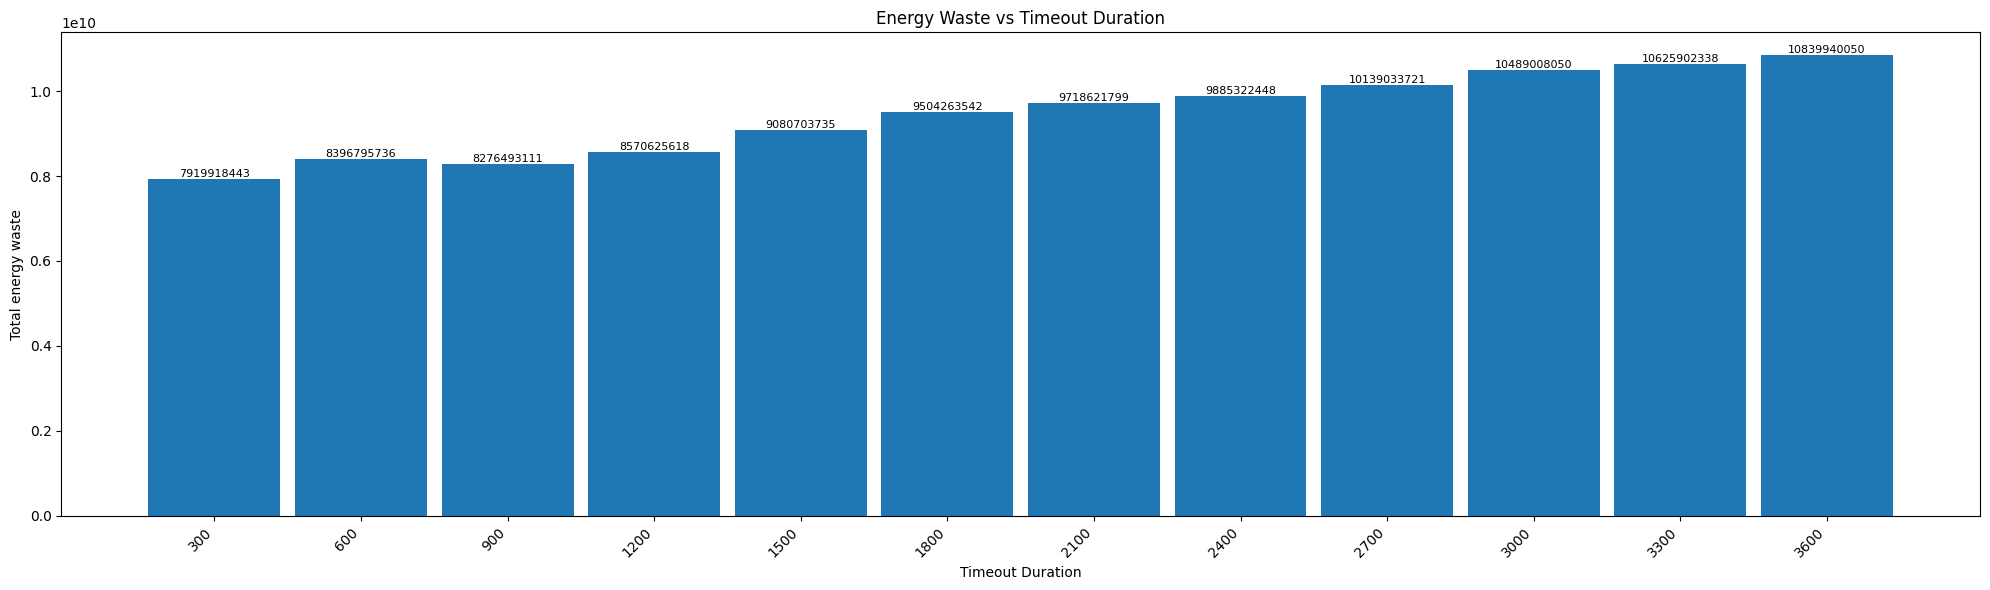

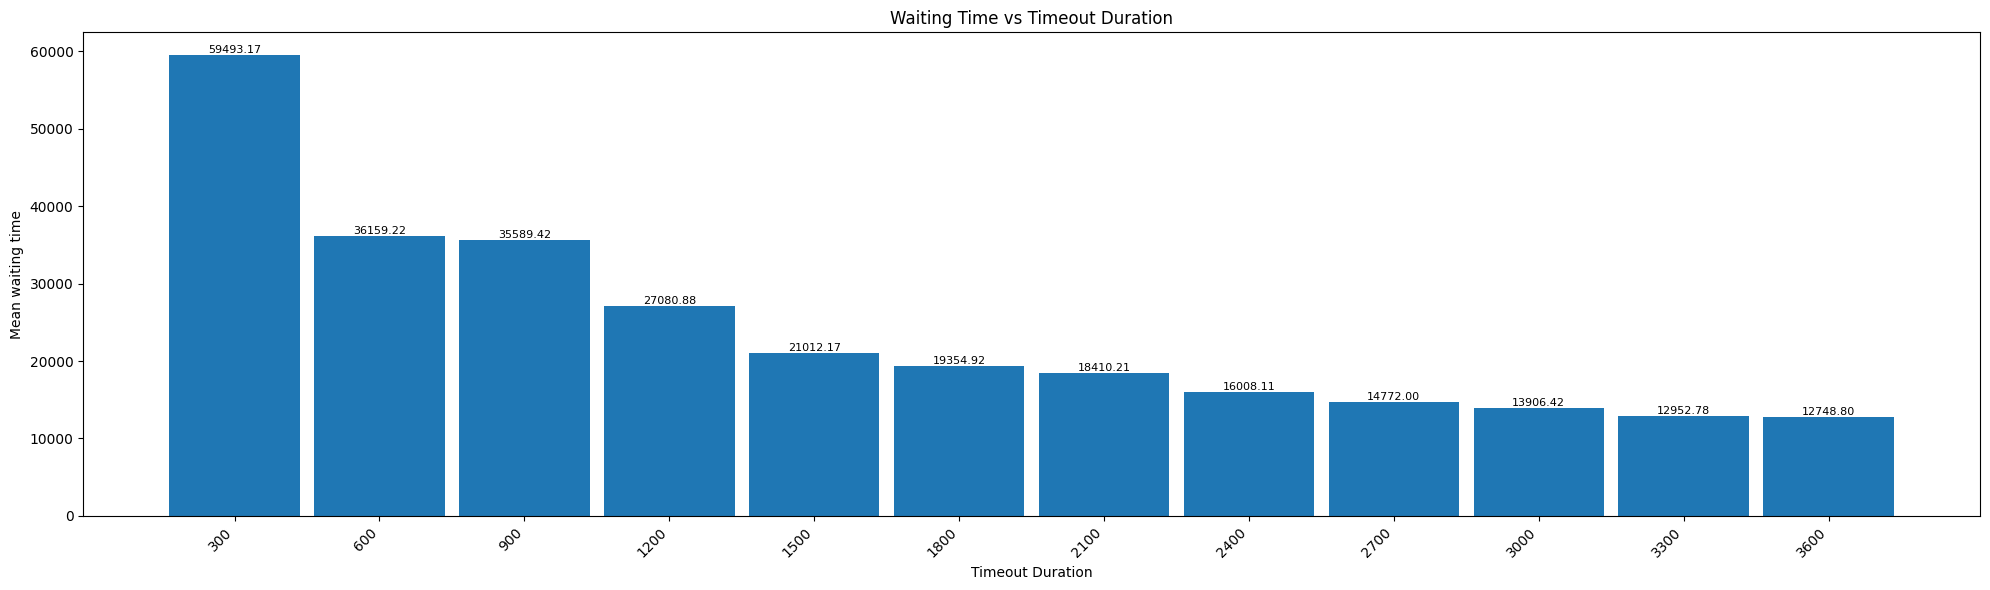

Saved: results\plots\summary.csv
Saved: results\plots\energy_waste_bar.png
Saved: results\plots\waiting_time_bar.png


In [111]:

rows = collect_metrics(results_dir)
if not rows:
    raise SystemExit(f"No metrics found under {results_dir}/generated_*/metrics.csv")

xs  = [r[0] for r in rows]
tew = [r[1] for r in rows]  # total_energy_waste
twt = [r[2] for r in rows]  # total_waiting_time
twt = (np.array(twt) / 200).tolist()

# Map semua xs menjadi string untuk plotting
xs_labels = [str(x) for x in xs] 

# Save a summary table (optional)
summary = pd.DataFrame({'folder': xs, 'total_energy_waste': tew, 'total_waiting_time': twt})
summary_path = output_dir / 'summary.csv'
summary.to_csv(summary_path, index=False)
display(summary)

# Plot 1: Energy waste bars
plot_bars(xs, tew, 'Timeout Duration', 'Total energy waste',
          'Energy Waste vs Timeout Duration', output_dir / 'energy_waste_bar.png')

# Plot 2: Waiting time bars
plot_bars(xs, twt, 'Timeout Duration', 'Mean waiting time',
          'Waiting Time vs Timeout Duration', output_dir / 'waiting_time_bar.png')

print("Saved:", summary_path)
print("Saved:", output_dir / 'energy_waste_bar.png')
print("Saved:", output_dir / 'waiting_time_bar.png')
